# train network
- use labeled dataset to create `DataGenerator`
- set up and visualize image augmentation
- set up and visualize `TrainingGenerator`
- specify and train network

This code is modified from [here](https://colab.research.google.com/github/jgraving/deepposekit/blob/master/examples/step3_train_model.ipynb).

In [47]:
# settings
dataset = r'D:\github\fish-tracking\label\datasets\tank_dataset_0.h5'
model_name = r'D:\github\fish-tracking\train\models\tank_model.h5'
validation_split = .1

In [48]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
from deepposekit.io import TrainingGenerator, DataGenerator
from deepposekit.augment import FlipAxis
import imgaug.augmenters as iaa
import imgaug as ia
from deepposekit.models import StackedDenseNet
from deepposekit.models import load_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from deepposekit.callbacks import Logger, ModelCheckpoint
import time
import h5py as h5
import os
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

%load_ext autoreload
%autoreload 2

data_generator = DataGenerator(dataset, zeros_to_nan=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## view sample frame

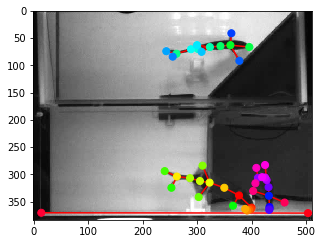

-1


In [18]:
frame_num = np.random.choice(len(data_generator))

image, keypoints = data_generator[frame_num]
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)
plt.show()
print(jdx)

## set up image augmentation

In [49]:
# settings
rotation = (-20, 20)
brightness = (-50, 50)

augmenter, sometimes = [], []


sometimes.append(iaa.Affine(scale={"x": (0.95, 1.05), "y": (0.95, 1.05)},
                            translate_percent={'x': (-0.05, 0.05), 'y': (-0.05, 0.05)},
                            shear=(-8, 8),
                            order=ia.ALL,
                            cval=ia.ALL,
                            mode=ia.ALL)
                 )
sometimes.append(iaa.Affine(scale=(0.8, 1.2),
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )

sometimes.append(iaa.AdditiveGaussianNoise(loc=0,
                                           scale=(0.0, 0.05*255))
                )

sometimes.append(iaa.Add(brightness))

augmenter.append(iaa.Sometimes(0.75, sometimes))
augmenter.append(iaa.Affine(rotate=rotation,
                            mode=ia.ALL,
                            order=ia.ALL,
                            cval=ia.ALL)
                 )
augmenter = iaa.Sequential(augmenter)



## show augmentation example

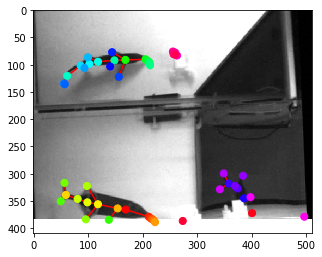

In [21]:
image, keypoints = data_generator[0]
image, keypoints = augmenter(images=image, keypoints=keypoints)
bins = np.all((keypoints>=0)[0], axis=1)  # bins of visible features
plt.figure(figsize=(5,5))
image = image[0] if image.shape[-1] is 3 else image[0, ..., 0]
cmap = None if image.shape[-1] is 3 else 'gray'
plt.imshow(image, cmap=cmap, interpolation='none')
for idx, jdx in enumerate(data_generator.graph):
    if jdx > -1 and np.all(keypoints[0, idx, :]>0) and np.all(keypoints[0, jdx, :]>0):
        plt.plot(
            [keypoints[0, idx, 0], keypoints[0, jdx, 0]],
            [keypoints[0, idx, 1], keypoints[0, jdx, 1]],
            'r-'
        )
plt.scatter(keypoints[0, bins, 0], keypoints[0, bins, 1],
            c=np.arange(bins.sum()), s=50, cmap=plt.cm.hsv, zorder=3)

plt.show()

# create `TrainingGenerator`
This creates a `TrainingGenerator` from the `DataGenerator` for training the model with annotated data. The `TrainingGenerator` uses the `DataGenerator` to load image-keypoints pairs and then applies the augmentation and draws the confidence maps for training the model.

If you're using `StackedDenseNet`, `StackedHourglass`, or `DeepLabCut` you should set `downsample_factor=2` for 1/4x outputs or `downsample_factor=3` for 1/8x outputs (1/8x is faster). Here it is set to `downsample_factor=3` to maximize speed. If you are using `LEAP` you should set the `downsample_factor=0` for 1x outputs.

The `validation_split` argument defines how many training examples to use for validation during training. If your dataset is small (such as initial annotations for active learning), you can set this to `validation_split=0`, which will just use the training set for model fitting. However, when using callbacks, make sure to set `monitor="loss"` instead of `monitor="val_loss"`.

Visualizing the outputs in the next section also works best with `downsample_factor=0`.

You can also look at the doc string for more explanation:


In [50]:
train_generator = TrainingGenerator(generator=data_generator,
                                    downsample_factor=2,
                                    augmenter=augmenter,
                                    sigma=5,
                                    validation_split=.1, 
                                    use_graph=True,
                                    graph_scale=1)
train_generator.get_config()

{'n_train': 18,
 'n_validation': 2,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 134,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_0.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 20,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (66, 2)}

In [51]:
train_generator.batch_size

2

# check `TrainingGenerator` output

D:\anaconda3\envs\dpk\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Method `Sequential.reseed()` is deprecated. Use `imgaug.augmenters.meta.Augmenter.seed_` instead.
  warn_deprecated(msg, stacklevel=3)


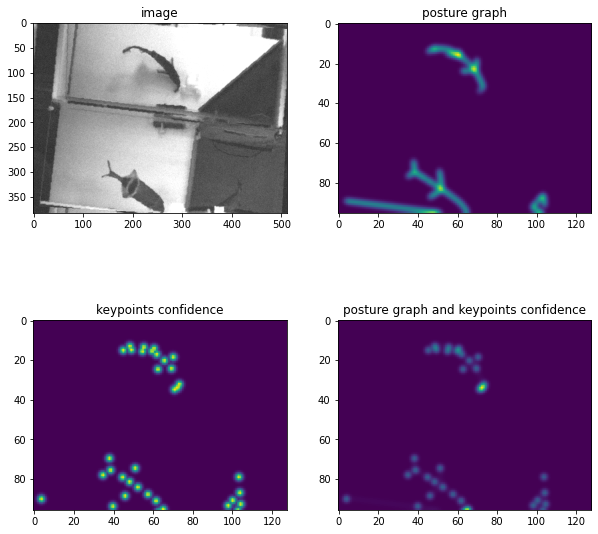

In [25]:
n_keypoints = data_generator.keypoints_shape[0]
batch = train_generator(batch_size=1, validation=False)[0]
inputs = batch[0]
outputs = batch[1]

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10,10))
ax1.set_title('image')
ax1.imshow(inputs[0,...,0], cmap='gray', vmin=0, vmax=255)

ax2.set_title('posture graph')
ax2.imshow(outputs[0,...,n_keypoints:-1].max(-1))

ax3.set_title('keypoints confidence')
ax3.imshow(outputs[0,...,:n_keypoints].max(-1))

ax4.set_title('posture graph and keypoints confidence')
ax4.imshow(outputs[0,...,-1], vmin=0)
plt.show()

train_generator.on_epoch_end()

# define a model

In [52]:
model = StackedDenseNet(train_generator, n_stacks=2, growth_rate=32, pretrained=True)
model.get_config()

{'name': 'StackedDenseNet',
 'n_stacks': 2,
 'n_transitions': 7,
 'growth_rate': 32,
 'bottleneck_factor': 1,
 'compression_factor': 0.5,
 'pretrained': True,
 'subpixel': True,
 'n_train': 18,
 'n_validation': 2,
 'validation_split': 0.1,
 'downsample_factor': 2,
 'output_shape': (96, 128),
 'n_output_channels': 134,
 'shuffle': True,
 'sigma': 5,
 'output_sigma': 1.25,
 'use_graph': True,
 'graph_scale': 1,
 'random_seed': None,
 'augmenter': True,
 'datapath': 'D:\\github\\fish-tracking\\label\\datasets\\tank_dataset_0.h5',
 'dataset': 'images',
 'generator': 'DataGenerator',
 'n_samples': 20,
 'image_shape': (384, 512, 1),
 'keypoints_shape': (66, 2)}

# test prediction speed
This generates a random set of input images for the model to test how fast the model can predict keypoint locations.

In [13]:
batch_size = 32
data_size = (10000,) + data_generator.image_shape
x = np.random.randint(0, 255, data_size, dtype="uint8")
y = model.predict(x[:256], batch_size=batch_size)  # make sure the model is in GPU memory
t0 = time.time()
y = model.predict(x, batch_size=32, verbose=1)
t1 = time.time()
print(x.shape[0] / (t1 - t0))

10000/10000 [==============================] - 106s 11ms/sample
94.2197550645878


# define training callbacks

In [57]:
logger = Logger(validation_batch_size=2,  # make sure this isn't too big!
                filepath=model_name[:-3]+'_log.h5'
)

reduce_lr = ReduceLROnPlateau(monitor="loss" if validation_split==0 else 'val_loss',
                              factor=0.2, verbose=1, patience=20)

model_checkpoint = ModelCheckpoint(
    model_name,
    monitor="loss" if validation_split==0 else 'val_loss',
    verbose=1,
    save_best_only=True,
)

early_stop = EarlyStopping(
    monitor="loss" if validation_split==0 else 'val_loss',
    min_delta=0.001,
    patience=100,
    verbose=1
)

callbacks = [logger, early_stop, reduce_lr, model_checkpoint]
# if validation_split>0:
#     callbacks.append(logger)  # todo: figure out why logger only works with validation_split>0
# callbacks = [early_stop, reduce_lr, model_checkpoint, logger]


# train

D:\anaconda3\envs\dpk\lib\site-packages\imgaug\imgaug.py:184: DeprecationWarning: Method `Sequential.reseed()` is deprecated. Use `imgaug.augmenters.meta.Augmenter.seed_` instead.
  warn_deprecated(msg, stacklevel=3)


Epoch 1/800
3/4 [=====================>........] - ETA: 5s - loss: 59.5360 - output_0_loss: 21.9127 - output_1_loss: 18.6146 - output_2_loss: 19.0087 evaluation_metrics: 
euclidean - mean: 54895.89 (0%:  3.25, 5%: 23.33, 25%: 158.32, 50%: 318.47, 75%: 141656.06, 95%: 141869.72, 100%: 141955.75) 
confidence - mean:  0.01 (0%:  0.00, 5%:  0.00, 25%:  0.00, 50%:  0.01, 75%:  0.01, 95%:  0.02, 100%:  0.02) 


Epoch 00001: val_loss did not improve from 63.44923
4/4 [==============================] - 25s 6s/step - loss: 57.2363 - output_0_loss: 21.2128 - output_1_loss: 17.8688 - output_2_loss: 18.1547 - val_loss: 63.7920 - val_output_0_loss: 21.9574 - val_output_1_loss: 20.8153 - val_output_2_loss: 21.0192


D:\github\DeepPoseKit\deepposekit\callbacks.py:116: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  with h5py.File(self.filepath) as h5file:


Epoch 2/800
3/4 [=====================>........] - ETA: 3s - loss: 57.8078 - output_0_loss: 22.3538 - output_1_loss: 17.8058 - output_2_loss: 17.6482 evaluation_metrics: 
euclidean - mean: 54870.40 (0%:  3.85, 5%: 16.34, 25%: 192.41, 50%: 327.59, 75%: 141655.90, 95%: 141774.29, 100%: 141896.32) 
confidence - mean:  0.02 (0%:  0.00, 5%:  0.00, 25%:  0.01, 50%:  0.01, 75%:  0.02, 95%:  0.04, 100%:  0.06) 


Epoch 00002: val_loss improved from 63.44923 to 59.71696, saving model to D:\github\fish-tracking\train\models\tank_model.h5
4/4 [==============================] - 19s 5s/step - loss: 52.8079 - output_0_loss: 20.1434 - output_1_loss: 16.2981 - output_2_loss: 16.3665 - val_loss: 59.7170 - val_output_0_loss: 21.4765 - val_output_1_loss: 19.1336 - val_output_2_loss: 19.1069
Epoch 3/800
3/4 [=====================>........] - ETA: 3s - loss: 52.6684 - output_0_loss: 20.5656 - output_1_loss: 16.0468 - output_2_loss: 16.0559evaluation_metrics: 
euclidean - mean: 54881.92 (0%:  2.85, 5%: 36.2

3/4 [=====================>........] - ETA: 3s - loss: 42.7589 - output_0_loss: 15.6502 - output_1_loss: 13.7198 - output_2_loss: 13.3889evaluation_metrics: 
euclidean - mean: 54896.54 (0%:  1.26, 5%:  8.94, 25%: 166.24, 50%: 325.63, 75%: 141660.04, 95%: 141868.73, 100%: 141938.54) 
confidence - mean:  0.03 (0%:  0.00, 5%:  0.00, 25%:  0.01, 50%:  0.02, 75%:  0.04, 95%:  0.09, 100%:  0.12) 


Epoch 00013: val_loss improved from 51.02895 to 49.66293, saving model to D:\github\fish-tracking\train\models\tank_model.h5
4/4 [==============================] - 17s 4s/step - loss: 42.2088 - output_0_loss: 15.3660 - output_1_loss: 13.5402 - output_2_loss: 13.3026 - val_loss: 49.6629 - val_output_0_loss: 17.1031 - val_output_1_loss: 16.1870 - val_output_2_loss: 16.3728
Epoch 14/800
3/4 [=====================>........] - ETA: 2s - loss: 40.0643 - output_0_loss: 14.4729 - output_1_loss: 12.8221 - output_2_loss: 12.7693evaluation_metrics: 
euclidean - mean: 54894.24 (0%:  0.45, 5%: 26.13, 25%: 165.

Epoch 25/800
3/4 [=====================>........] - ETA: 3s - loss: 39.1438 - output_0_loss: 14.0109 - output_1_loss: 12.6825 - output_2_loss: 12.4504evaluation_metrics: 
euclidean - mean: 54897.14 (0%:  1.60, 5%: 16.33, 25%: 143.73, 50%: 326.73, 75%: 141767.96, 95%: 141869.32, 100%: 141871.07) 
confidence - mean:  0.01 (0%:  0.00, 5%:  0.00, 25%:  0.01, 50%:  0.01, 75%:  0.02, 95%:  0.04, 100%:  0.07) 


Epoch 00025: val_loss did not improve from 49.66293
4/4 [==============================] - 18s 4s/step - loss: 38.4091 - output_0_loss: 13.7615 - output_1_loss: 12.4430 - output_2_loss: 12.2046 - val_loss: 60.6951 - val_output_0_loss: 20.2671 - val_output_1_loss: 20.2712 - val_output_2_loss: 20.1568
Epoch 26/800
3/4 [=====================>........] - ETA: 3s - loss: 39.9557 - output_0_loss: 14.1228 - output_1_loss: 13.0242 - output_2_loss: 12.8087 evaluation_metrics: 
euclidean - mean: 54898.17 (0%:  0.54, 5%: 20.51, 25%: 147.75, 50%: 319.81, 75%: 141724.98, 95%: 141869.18, 100%: 1418

Epoch 37/800
3/4 [=====================>........] - ETA: 3s - loss: 35.6887 - output_0_loss: 12.8877 - output_1_loss: 11.5679 - output_2_loss: 11.2332 evaluation_metrics: 
euclidean - mean: 54848.94 (0%:  0.39, 5%:  2.50, 25%: 50.26, 50%: 255.55, 75%: 141679.27, 95%: 141869.66, 100%: 141872.25) 
confidence - mean:  0.02 (0%:  0.00, 5%:  0.00, 25%:  0.01, 50%:  0.02, 75%:  0.03, 95%:  0.06, 100%:  0.08) 


Epoch 00037: val_loss did not improve from 49.66293
4/4 [==============================] - 18s 5s/step - loss: 34.9917 - output_0_loss: 12.6430 - output_1_loss: 11.3545 - output_2_loss: 10.9942 - val_loss: 56.4743 - val_output_0_loss: 18.8300 - val_output_1_loss: 18.7070 - val_output_2_loss: 18.9373
Epoch 38/800
3/4 [=====================>........] - ETA: 3s - loss: 34.5765 - output_0_loss: 12.6087 - output_1_loss: 11.2011 - output_2_loss: 10.7667 evaluation_metrics: 
euclidean - mean: 54845.66 (0%:  0.13, 5%:  2.39, 25%: 42.46, 50%: 308.50, 75%: 141680.42, 95%: 141869.28, 100%: 14187

Epoch 49/800
3/4 [=====================>........] - ETA: 3s - loss: 32.2528 - output_0_loss: 11.8308 - output_1_loss: 10.4653 - output_2_loss: 9.9568evaluation_metrics: 
euclidean - mean: 54848.21 (0%:  0.84, 5%:  2.01, 25%: 30.29, 50%: 228.17, 75%: 141774.20, 95%: 141941.25, 100%: 141959.74) 
confidence - mean:  0.04 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.03, 75%:  0.05, 95%:  0.08, 100%:  0.11) 


Epoch 00049: val_loss did not improve from 49.66293
4/4 [==============================] - 18s 4s/step - loss: 32.3051 - output_0_loss: 12.0167 - output_1_loss: 10.4037 - output_2_loss: 9.8848 - val_loss: 50.4489 - val_output_0_loss: 17.3482 - val_output_1_loss: 16.6436 - val_output_2_loss: 16.4572
Epoch 50/800
3/4 [=====================>........] - ETA: 3s - loss: 33.7273 - output_0_loss: 12.2076 - output_1_loss: 10.9768 - output_2_loss: 10.5429evaluation_metrics: 
euclidean - mean: 54840.85 (0%:  0.98, 5%:  2.00, 25%: 30.46, 50%: 183.53, 75%: 141773.05, 95%: 141921.86, 100%: 141946.90

3/4 [=====================>........] - ETA: 3s - loss: 29.0129 - output_0_loss: 10.7726 - output_1_loss: 9.4088 - output_2_loss: 8.8314 evaluation_metrics: 
euclidean - mean: 54868.78 (0%:  0.31, 5%:  1.81, 25%: 27.21, 50%: 279.41, 75%: 141842.59, 95%: 141951.95, 100%: 141963.30) 
confidence - mean:  0.04 (0%:  0.00, 5%:  0.01, 25%:  0.02, 50%:  0.03, 75%:  0.05, 95%:  0.09, 100%:  0.12) 


Epoch 00060: val_loss did not improve from 46.85039
4/4 [==============================] - 19s 5s/step - loss: 28.9345 - output_0_loss: 10.6822 - output_1_loss: 9.3967 - output_2_loss: 8.8557 - val_loss: 51.7168 - val_output_0_loss: 17.2870 - val_output_1_loss: 17.2538 - val_output_2_loss: 17.1760
Epoch 61/800
3/4 [=====================>........] - ETA: 3s - loss: 31.9321 - output_0_loss: 11.9274 - output_1_loss: 10.3079 - output_2_loss: 9.6967evaluation_metrics: 
euclidean - mean: 54876.55 (0%:  0.40, 5%:  1.89, 25%: 22.02, 50%: 305.68, 75%: 141842.64, 95%: 141960.25, 100%: 141979.30) 
confidence -

3/4 [=====================>........] - ETA: 2s - loss: 29.3386 - output_0_loss: 10.7543 - output_1_loss: 9.5621 - output_2_loss: 9.0222 evaluation_metrics: 
euclidean - mean: 54849.23 (0%:  0.49, 5%:  1.50, 25%: 18.24, 50%: 143.72, 75%: 141789.97, 95%: 141960.90, 100%: 141983.45) 
confidence - mean:  0.06 (0%:  0.01, 5%:  0.01, 25%:  0.02, 50%:  0.05, 75%:  0.08, 95%:  0.15, 100%:  0.24) 


Epoch 00071: val_loss improved from 43.15796 to 43.01149, saving model to D:\github\fish-tracking\train\models\tank_model.h5
4/4 [==============================] - 17s 4s/step - loss: 31.0513 - output_0_loss: 11.5184 - output_1_loss: 10.0655 - output_2_loss: 9.4675 - val_loss: 43.0115 - val_output_0_loss: 15.4359 - val_output_1_loss: 13.9408 - val_output_2_loss: 13.6347
Epoch 72/800
3/4 [=====================>........] - ETA: 2s - loss: 27.9545 - output_0_loss: 10.3444 - output_1_loss: 9.0575 - output_2_loss: 8.5526evaluation_metrics: 
euclidean - mean: 54855.96 (0%:  0.38, 5%:  1.71, 25%: 21.05, 50

3/4 [=====================>........] - ETA: 3s - loss: 34.3861 - output_0_loss: 13.1468 - output_1_loss: 11.0211 - output_2_loss: 10.2181evaluation_metrics: 
euclidean - mean: 54843.71 (0%:  0.32, 5%:  1.64, 25%: 10.14, 50%: 136.76, 75%: 141796.62, 95%: 141960.65, 100%: 141980.63) 
confidence - mean:  0.08 (0%:  0.01, 5%:  0.01, 25%:  0.03, 50%:  0.07, 75%:  0.11, 95%:  0.23, 100%:  0.34) 


Epoch 00082: val_loss improved from 40.44164 to 40.29069, saving model to D:\github\fish-tracking\train\models\tank_model.h5
4/4 [==============================] - 18s 5s/step - loss: 32.0550 - output_0_loss: 12.2659 - output_1_loss: 10.2973 - output_2_loss: 9.4919 - val_loss: 40.2907 - val_output_0_loss: 14.5656 - val_output_1_loss: 13.1719 - val_output_2_loss: 12.5532
Epoch 83/800
3/4 [=====================>........] - ETA: 3s - loss: 27.6663 - output_0_loss: 10.3112 - output_1_loss: 8.9775 - output_2_loss: 8.3776 evaluation_metrics: 
euclidean - mean: 54855.67 (0%:  0.30, 5%:  1.72, 25%: 12.55, 

4/4 [==============================] - 17s 4s/step - loss: 28.1356 - output_0_loss: 10.7177 - output_1_loss: 9.0833 - output_2_loss: 8.3346 - val_loss: 38.2000 - val_output_0_loss: 14.0607 - val_output_1_loss: 12.4658 - val_output_2_loss: 11.6735
Epoch 94/800
3/4 [=====================>........] - ETA: 3s - loss: 30.6182 - output_0_loss: 11.7366 - output_1_loss: 9.9028 - output_2_loss: 8.9788 evaluation_metrics: 
euclidean - mean: 54844.52 (0%:  0.75, 5%:  1.51, 25%:  9.69, 50%: 128.92, 75%: 141782.78, 95%: 141960.43, 100%: 141981.56) 
confidence - mean:  0.10 (0%:  0.01, 5%:  0.01, 25%:  0.03, 50%:  0.07, 75%:  0.12, 95%:  0.37, 100%:  0.63) 


Epoch 00094: val_loss did not improve from 38.20001
4/4 [==============================] - 17s 4s/step - loss: 28.8352 - output_0_loss: 10.9054 - output_1_loss: 9.3832 - output_2_loss: 8.5466 - val_loss: 38.7231 - val_output_0_loss: 14.1154 - val_output_1_loss: 12.6857 - val_output_2_loss: 11.9219
Epoch 95/800
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 3s - loss: 28.0024 - output_0_loss: 10.6445 - output_1_loss: 9.0919 - output_2_loss: 8.2659 evaluation_metrics: 
euclidean - mean: 54848.59 (0%:  0.41, 5%:  1.26, 25%:  8.19, 50%: 105.18, 75%: 141866.12, 95%: 141962.41, 100%: 141979.07) 
confidence - mean:  0.11 (0%:  0.01, 5%:  0.01, 25%:  0.04, 50%:  0.08, 75%:  0.15, 95%:  0.36, 100%:  0.55) 


Epoch 00105: val_loss did not improve from 36.61703
4/4 [==============================] - 17s 4s/step - loss: 28.6956 - output_0_loss: 10.9375 - output_1_loss: 9.3304 - output_2_loss: 8.4276 - val_loss: 37.9505 - val_output_0_loss: 13.9566 - val_output_1_loss: 12.4231 - val_output_2_loss: 11.5707
Epoch 106/800
3/4 [=====================>........] - ETA: 3s - loss: 28.6238 - output_0_loss: 10.8376 - output_1_loss: 9.3613 - output_2_loss: 8.4249evaluation_metrics: 
euclidean - mean: 54857.50 (0%:  0.61, 5%:  1.19, 25%:  6.19, 50%: 103.55, 75%: 141883.68, 95%: 141962.41, 100%: 141979.52) 
confidence -

Epoch 117/800
3/4 [=====================>........] - ETA: 3s - loss: 29.1241 - output_0_loss: 11.3212 - output_1_loss: 9.4428 - output_2_loss: 8.3601 evaluation_metrics: 
euclidean - mean: 54849.75 (0%:  0.78, 5%:  1.27, 25%:  5.60, 50%: 93.75, 75%: 141865.89, 95%: 141961.97, 100%: 141980.31) 
confidence - mean:  0.13 (0%:  0.01, 5%:  0.01, 25%:  0.04, 50%:  0.09, 75%:  0.17, 95%:  0.45, 100%:  0.66) 


Epoch 00117: val_loss did not improve from 36.27559
4/4 [==============================] - 17s 4s/step - loss: 28.4669 - output_0_loss: 11.0107 - output_1_loss: 9.2623 - output_2_loss: 8.1939 - val_loss: 36.8594 - val_output_0_loss: 13.5778 - val_output_1_loss: 12.0871 - val_output_2_loss: 11.1945
Epoch 118/800
3/4 [=====================>........] - ETA: 3s - loss: 27.3729 - output_0_loss: 10.1197 - output_1_loss: 9.0194 - output_2_loss: 8.2337  evaluation_metrics: 
euclidean - mean: 54846.39 (0%:  0.57, 5%:  1.28, 25%:  6.78, 50%: 80.87, 75%: 141867.91, 95%: 141961.54, 100%: 141996.43)

Epoch 129/800
3/4 [=====================>........] - ETA: 3s - loss: 25.1563 - output_0_loss: 9.8277 - output_1_loss: 8.2146 - output_2_loss: 7.1141evaluation_metrics: 
euclidean - mean: 54848.35 (0%:  0.39, 5%:  0.99, 25%:  5.45, 50%: 62.03, 75%: 141866.83, 95%: 141960.93, 100%: 141979.83) 
confidence - mean:  0.14 (0%:  0.01, 5%:  0.02, 25%:  0.04, 50%:  0.11, 75%:  0.18, 95%:  0.48, 100%:  0.59) 


Epoch 00129: val_loss did not improve from 34.28323
4/4 [==============================] - 18s 4s/step - loss: 26.5863 - output_0_loss: 10.3556 - output_1_loss: 8.6565 - output_2_loss: 7.5741 - val_loss: 36.1301 - val_output_0_loss: 13.5697 - val_output_1_loss: 11.7474 - val_output_2_loss: 10.8130
Epoch 130/800
3/4 [=====================>........] - ETA: 3s - loss: 24.9757 - output_0_loss: 9.7649 - output_1_loss: 8.1592 - output_2_loss: 7.0516evaluation_metrics: 
euclidean - mean: 54845.57 (0%:  0.39, 5%:  1.10, 25%:  5.80, 50%: 93.31, 75%: 141856.98, 95%: 141960.80, 100%: 141979.72) 
con

Epoch 141/800
3/4 [=====================>........] - ETA: 3s - loss: 26.9775 - output_0_loss: 10.7839 - output_1_loss: 8.6719 - output_2_loss: 7.5217evaluation_metrics: 
euclidean - mean: 54839.79 (0%:  0.09, 5%:  1.00, 25%:  4.98, 50%: 65.94, 75%: 141850.31, 95%: 141961.61, 100%: 141979.07) 
confidence - mean:  0.15 (0%:  0.01, 5%:  0.02, 25%:  0.04, 50%:  0.10, 75%:  0.19, 95%:  0.59, 100%:  0.70) 


Epoch 00141: val_loss did not improve from 34.28323
4/4 [==============================] - 18s 5s/step - loss: 26.6712 - output_0_loss: 10.6488 - output_1_loss: 8.5747 - output_2_loss: 7.4477 - val_loss: 36.2596 - val_output_0_loss: 13.8267 - val_output_1_loss: 11.7607 - val_output_2_loss: 10.6722
Epoch 142/800
3/4 [=====================>........] - ETA: 3s - loss: 25.9175 - output_0_loss: 10.1079 - output_1_loss: 8.3983 - output_2_loss: 7.4113evaluation_metrics: 
euclidean - mean: 54835.60 (0%:  0.21, 5%:  1.11, 25%:  6.02, 50%: 49.69, 75%: 141859.56, 95%: 141961.96, 100%: 141978.62) 
c

4/4 [==============================] - 17s 4s/step - loss: 26.6619 - output_0_loss: 10.6147 - output_1_loss: 8.6552 - output_2_loss: 7.3919 - val_loss: 34.0466 - val_output_0_loss: 12.7445 - val_output_1_loss: 11.2299 - val_output_2_loss: 10.0722
Epoch 153/800
3/4 [=====================>........] - ETA: 3s - loss: 24.1349 - output_0_loss: 10.0680 - output_1_loss: 7.6576 - output_2_loss: 6.4093evaluation_metrics: 
euclidean - mean: 54825.84 (0%:  0.16, 5%:  0.89, 25%:  4.17, 50%: 40.81, 75%: 141850.62, 95%: 141961.42, 100%: 141979.01) 
confidence - mean:  0.18 (0%:  0.01, 5%:  0.02, 25%:  0.05, 50%:  0.13, 75%:  0.24, 95%:  0.63, 100%:  0.70) 


Epoch 00153: val_loss did not improve from 34.04662
4/4 [==============================] - 17s 4s/step - loss: 25.0548 - output_0_loss: 10.3829 - output_1_loss: 7.9687 - output_2_loss: 6.7032 - val_loss: 34.1280 - val_output_0_loss: 12.7555 - val_output_1_loss: 11.2642 - val_output_2_loss: 10.1083
Epoch 154/800
3/4 [=====================>.......

3/4 [=====================>........] - ETA: 3s - loss: 26.6729 - output_0_loss: 10.4560 - output_1_loss: 8.6988 - output_2_loss: 7.5181evaluation_metrics: 
euclidean - mean: 54825.98 (0%:  0.10, 5%:  0.96, 25%:  4.52, 50%: 45.08, 75%: 141847.43, 95%: 141961.26, 100%: 141979.10) 
confidence - mean:  0.19 (0%:  0.01, 5%:  0.01, 25%:  0.05, 50%:  0.15, 75%:  0.23, 95%:  0.67, 100%:  0.79) 


Epoch 00164: val_loss improved from 33.92963 to 33.77580, saving model to D:\github\fish-tracking\train\models\tank_model.h5
4/4 [==============================] - 17s 4s/step - loss: 25.5772 - output_0_loss: 10.0777 - output_1_loss: 8.3473 - output_2_loss: 7.1522 - val_loss: 33.7758 - val_output_0_loss: 12.4004 - val_output_1_loss: 11.2677 - val_output_2_loss: 10.1076
Epoch 165/800
3/4 [=====================>........] - ETA: 3s - loss: 28.1232 - output_0_loss: 11.1781 - output_1_loss: 9.1402 - output_2_loss: 7.8049 evaluation_metrics: 
euclidean - mean: 54824.41 (0%:  0.04, 5%:  0.94, 25%:  4.57, 50%

Epoch 176/800
3/4 [=====================>........] - ETA: 2s - loss: 24.1251 - output_0_loss: 9.7879 - output_1_loss: 7.8267 - output_2_loss: 6.5105evaluation_metrics: 
euclidean - mean: 54826.80 (0%:  0.06, 5%:  0.92, 25%:  4.11, 50%: 44.74, 75%: 141847.26, 95%: 141961.71, 100%: 141998.80) 
confidence - mean:  0.19 (0%:  0.01, 5%:  0.02, 25%:  0.05, 50%:  0.15, 75%:  0.25, 95%:  0.64, 100%:  0.77) 


Epoch 00176: val_loss did not improve from 33.77580
4/4 [==============================] - 16s 4s/step - loss: 23.5638 - output_0_loss: 9.5427 - output_1_loss: 7.6443 - output_2_loss: 6.3769 - val_loss: 34.1075 - val_output_0_loss: 12.6044 - val_output_1_loss: 11.3177 - val_output_2_loss: 10.1855
Epoch 177/800
3/4 [=====================>........] - ETA: 2s - loss: 24.9085 - output_0_loss: 10.3692 - output_1_loss: 7.9170 - output_2_loss: 6.6224evaluation_metrics: 
euclidean - mean: 54824.31 (0%:  0.05, 5%:  0.95, 25%:  4.22, 50%: 44.83, 75%: 141847.53, 95%: 141961.61, 100%: 141979.18) 
con

4/4 [==============================] - 18s 5s/step - loss: 25.4983 - output_0_loss: 10.1464 - output_1_loss: 8.3040 - output_2_loss: 7.0478 - val_loss: 33.7662 - val_output_0_loss: 12.3993 - val_output_1_loss: 11.2353 - val_output_2_loss: 10.1316
Epoch 188/800
3/4 [=====================>........] - ETA: 2s - loss: 28.1525 - output_0_loss: 11.3016 - output_1_loss: 9.0224 - output_2_loss: 7.8285evaluation_metrics: 
euclidean - mean: 54828.55 (0%:  0.08, 5%:  0.92, 25%:  4.21, 50%: 45.28, 75%: 141847.85, 95%: 141961.59, 100%: 141999.17) 
confidence - mean:  0.20 (0%:  0.01, 5%:  0.02, 25%:  0.05, 50%:  0.15, 75%:  0.25, 95%:  0.67, 100%:  0.79) 


Epoch 00188: val_loss improved from 33.76619 to 33.76262, saving model to D:\github\fish-tracking\train\models\tank_model.h5
4/4 [==============================] - 17s 4s/step - loss: 26.9900 - output_0_loss: 10.8863 - output_1_loss: 8.6139 - output_2_loss: 7.4898 - val_loss: 33.7626 - val_output_0_loss: 12.3870 - val_output_1_loss: 11.2374 - va

4/4 [==============================] - 18s 4s/step - loss: 30.3570 - output_0_loss: 12.1977 - output_1_loss: 9.7567 - output_2_loss: 8.4026 - val_loss: 33.6312 - val_output_0_loss: 12.3493 - val_output_1_loss: 11.1946 - val_output_2_loss: 10.0873
Epoch 199/800
3/4 [=====================>........] - ETA: 3s - loss: 23.0977 - output_0_loss: 9.3444 - output_1_loss: 7.4596 - output_2_loss: 6.2938evaluation_metrics: 
euclidean - mean: 54832.47 (0%:  0.28, 5%:  0.93, 25%:  4.31, 50%: 44.81, 75%: 141862.84, 95%: 141961.55, 100%: 141999.31) 
confidence - mean:  0.20 (0%:  0.01, 5%:  0.02, 25%:  0.05, 50%:  0.16, 75%:  0.25, 95%:  0.70, 100%:  0.82) 


Epoch 00199: val_loss did not improve from 33.63117
4/4 [==============================] - 17s 4s/step - loss: 25.8791 - output_0_loss: 10.6775 - output_1_loss: 8.2154 - output_2_loss: 6.9862 - val_loss: 33.6509 - val_output_0_loss: 12.3504 - val_output_1_loss: 11.2004 - val_output_2_loss: 10.1001
Epoch 200/800
3/4 [=====================>........

Epoch 210/800
3/4 [=====================>........] - ETA: 2s - loss: 28.4461 - output_0_loss: 11.3907 - output_1_loss: 9.1696 - output_2_loss: 7.8858evaluation_metrics: 
euclidean - mean: 54829.54 (0%:  0.26, 5%:  0.87, 25%:  3.90, 50%: 64.36, 75%: 141852.26, 95%: 141961.49, 100%: 141999.48) 
confidence - mean:  0.21 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.17, 75%:  0.26, 95%:  0.69, 100%:  0.84) 


Epoch 00210: val_loss did not improve from 33.54366
4/4 [==============================] - 16s 4s/step - loss: 26.6261 - output_0_loss: 10.7605 - output_1_loss: 8.5594 - output_2_loss: 7.3062 - val_loss: 33.5846 - val_output_0_loss: 12.2862 - val_output_1_loss: 11.1827 - val_output_2_loss: 10.1157
Epoch 211/800
3/4 [=====================>........] - ETA: 3s - loss: 25.4339 - output_0_loss: 10.3114 - output_1_loss: 8.2771 - output_2_loss: 6.8454evaluation_metrics: 
euclidean - mean: 54829.55 (0%:  0.26, 5%:  0.88, 25%:  3.89, 50%: 64.33, 75%: 141852.24, 95%: 141961.50, 100%: 141999.45) 
c

Epoch 222/800
3/4 [=====================>........] - ETA: 3s - loss: 24.3990 - output_0_loss: 10.0372 - output_1_loss: 7.7775 - output_2_loss: 6.5843 evaluation_metrics: 
euclidean - mean: 54828.93 (0%:  0.30, 5%:  0.89, 25%:  3.85, 50%: 50.49, 75%: 141847.93, 95%: 141961.49, 100%: 141999.37) 
confidence - mean:  0.21 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.17, 75%:  0.26, 95%:  0.68, 100%:  0.83) 


Epoch 00222: val_loss did not improve from 33.40474
4/4 [==============================] - 18s 4s/step - loss: 25.1758 - output_0_loss: 10.4335 - output_1_loss: 7.9914 - output_2_loss: 6.7508 - val_loss: 33.5632 - val_output_0_loss: 12.2749 - val_output_1_loss: 11.1814 - val_output_2_loss: 10.1069
Epoch 223/800
3/4 [=====================>........] - ETA: 3s - loss: 26.3032 - output_0_loss: 10.8202 - output_1_loss: 8.4612 - output_2_loss: 7.0218 evaluation_metrics: 
euclidean - mean: 54828.93 (0%:  0.31, 5%:  0.91, 25%:  3.86, 50%: 50.49, 75%: 141847.93, 95%: 141961.49, 100%: 141999.37) 

Epoch 234/800
3/4 [=====================>........] - ETA: 3s - loss: 24.6720 - output_0_loss: 9.9286 - output_1_loss: 8.0346 - output_2_loss: 6.7088 evaluation_metrics: 
euclidean - mean: 54827.03 (0%:  0.26, 5%:  0.97, 25%:  3.86, 50%: 64.24, 75%: 141847.32, 95%: 141961.54, 100%: 141999.57) 
confidence - mean:  0.21 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.17, 75%:  0.28, 95%:  0.70, 100%:  0.84) 


Epoch 00234: val_loss did not improve from 33.40474
4/4 [==============================] - 18s 5s/step - loss: 23.3175 - output_0_loss: 9.3401 - output_1_loss: 7.5721 - output_2_loss: 6.4053 - val_loss: 33.6990 - val_output_0_loss: 12.2929 - val_output_1_loss: 11.2289 - val_output_2_loss: 10.1772
Epoch 235/800
3/4 [=====================>........] - ETA: 3s - loss: 22.4502 - output_0_loss: 9.0792 - output_1_loss: 7.2873 - output_2_loss: 6.0837evaluation_metrics: 
euclidean - mean: 54827.03 (0%:  0.27, 5%:  0.97, 25%:  3.86, 50%: 64.20, 75%: 141847.31, 95%: 141961.58, 100%: 141999.57) 
con

Epoch 246/800
3/4 [=====================>........] - ETA: 3s - loss: 25.6325 - output_0_loss: 10.4756 - output_1_loss: 8.2807 - output_2_loss: 6.8761 evaluation_metrics: 
euclidean - mean: 54825.99 (0%:  0.26, 5%:  0.96, 25%:  3.86, 50%: 64.30, 75%: 141847.31, 95%: 141961.63, 100%: 141999.45) 
confidence - mean:  0.21 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.17, 75%:  0.28, 95%:  0.70, 100%:  0.85) 


Epoch 00246: val_loss did not improve from 33.40474
4/4 [==============================] - 19s 5s/step - loss: 24.9155 - output_0_loss: 10.1393 - output_1_loss: 8.0494 - output_2_loss: 6.7269 - val_loss: 33.6632 - val_output_0_loss: 12.2766 - val_output_1_loss: 11.2187 - val_output_2_loss: 10.1679
Epoch 247/800
3/4 [=====================>........] - ETA: 3s - loss: 24.8149 - output_0_loss: 10.4098 - output_1_loss: 7.9141 - output_2_loss: 6.4910 evaluation_metrics: 
euclidean - mean: 54825.99 (0%:  0.26, 5%:  0.95, 25%:  3.86, 50%: 64.30, 75%: 141847.32, 95%: 141961.63, 100%: 141999.45) 

Epoch 258/800
3/4 [=====================>........] - ETA: 3s - loss: 24.1899 - output_0_loss: 9.8730 - output_1_loss: 7.8286 - output_2_loss: 6.4882 evaluation_metrics: 
euclidean - mean: 54825.91 (0%:  0.26, 5%:  0.94, 25%:  3.86, 50%: 64.40, 75%: 141847.37, 95%: 141961.65, 100%: 141999.37) 
confidence - mean:  0.22 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.18, 75%:  0.29, 95%:  0.70, 100%:  0.85) 


Epoch 00258: val_loss did not improve from 33.40474
4/4 [==============================] - 19s 5s/step - loss: 24.6655 - output_0_loss: 10.0883 - output_1_loss: 7.9882 - output_2_loss: 6.5890 - val_loss: 33.7513 - val_output_0_loss: 12.2756 - val_output_1_loss: 11.2620 - val_output_2_loss: 10.2138
Epoch 259/800
3/4 [=====================>........] - ETA: 3s - loss: 25.0411 - output_0_loss: 10.1157 - output_1_loss: 8.1089 - output_2_loss: 6.8165evaluation_metrics: 
euclidean - mean: 54825.91 (0%:  0.26, 5%:  0.94, 25%:  3.86, 50%: 64.40, 75%: 141847.37, 95%: 141961.63, 100%: 141999.43) 
c

Epoch 270/800
3/4 [=====================>........] - ETA: 3s - loss: 24.7867 - output_0_loss: 10.0066 - output_1_loss: 8.0178 - output_2_loss: 6.7624 evaluation_metrics: 
euclidean - mean: 54825.92 (0%:  0.31, 5%:  0.94, 25%:  3.86, 50%: 64.40, 75%: 141847.35, 95%: 141961.64, 100%: 141999.48) 
confidence - mean:  0.22 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.18, 75%:  0.28, 95%:  0.70, 100%:  0.85) 


Epoch 00270: val_loss did not improve from 33.40474
4/4 [==============================] - 18s 5s/step - loss: 24.6381 - output_0_loss: 9.9688 - output_1_loss: 7.9702 - output_2_loss: 6.6991 - val_loss: 33.7326 - val_output_0_loss: 12.2716 - val_output_1_loss: 11.2502 - val_output_2_loss: 10.2107
Epoch 271/800
3/4 [=====================>........] - ETA: 3s - loss: 27.1766 - output_0_loss: 10.8653 - output_1_loss: 8.8225 - output_2_loss: 7.4888evaluation_metrics: 
euclidean - mean: 54825.92 (0%:  0.31, 5%:  0.95, 25%:  3.86, 50%: 64.40, 75%: 141847.35, 95%: 141961.63, 100%: 141999.48) 
c

Epoch 282/800
3/4 [=====================>........] - ETA: 3s - loss: 26.4102 - output_0_loss: 10.7389 - output_1_loss: 8.5301 - output_2_loss: 7.1412evaluation_metrics: 
euclidean - mean: 54826.94 (0%:  0.31, 5%:  0.92, 25%:  3.89, 50%: 64.42, 75%: 141847.35, 95%: 141961.62, 100%: 141999.45) 
confidence - mean:  0.22 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.18, 75%:  0.28, 95%:  0.70, 100%:  0.85) 


Epoch 00282: val_loss did not improve from 33.40474
4/4 [==============================] - 18s 5s/step - loss: 24.3426 - output_0_loss: 9.9153 - output_1_loss: 7.8442 - output_2_loss: 6.5831 - val_loss: 33.7216 - val_output_0_loss: 12.2684 - val_output_1_loss: 11.2448 - val_output_2_loss: 10.2084
Epoch 283/800
3/4 [=====================>........] - ETA: 3s - loss: 24.4210 - output_0_loss: 9.7558 - output_1_loss: 8.0061 - output_2_loss: 6.6591evaluation_metrics: 
euclidean - mean: 54826.94 (0%:  0.31, 5%:  0.94, 25%:  3.89, 50%: 64.40, 75%: 141847.35, 95%: 141961.63, 100%: 141999.45) 
con

Epoch 294/800
3/4 [=====================>........] - ETA: 3s - loss: 25.8867 - output_0_loss: 10.4278 - output_1_loss: 8.3908 - output_2_loss: 7.0681 evaluation_metrics: 
euclidean - mean: 54826.94 (0%:  0.26, 5%:  0.96, 25%:  3.88, 50%: 64.40, 75%: 141847.35, 95%: 141961.57, 100%: 141999.43) 
confidence - mean:  0.22 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.17, 75%:  0.29, 95%:  0.71, 100%:  0.85) 


Epoch 00294: val_loss did not improve from 33.40474
4/4 [==============================] - 18s 5s/step - loss: 25.2896 - output_0_loss: 10.2188 - output_1_loss: 8.2081 - output_2_loss: 6.8627 - val_loss: 33.7857 - val_output_0_loss: 12.2821 - val_output_1_loss: 11.2667 - val_output_2_loss: 10.2369
Epoch 295/800
3/4 [=====================>........] - ETA: 3s - loss: 26.9205 - output_0_loss: 11.0116 - output_1_loss: 8.7356 - output_2_loss: 7.1733 evaluation_metrics: 
euclidean - mean: 54826.94 (0%:  0.26, 5%:  0.96, 25%:  3.88, 50%: 64.40, 75%: 141847.35, 95%: 141961.57, 100%: 141999.43) 

Epoch 306/800
3/4 [=====================>........] - ETA: 3s - loss: 26.6670 - output_0_loss: 10.8038 - output_1_loss: 8.6119 - output_2_loss: 7.2514evaluation_metrics: 
euclidean - mean: 54826.94 (0%:  0.26, 5%:  0.93, 25%:  3.88, 50%: 64.40, 75%: 141847.35, 95%: 141961.60, 100%: 141999.40) 
confidence - mean:  0.22 (0%:  0.01, 5%:  0.02, 25%:  0.06, 50%:  0.17, 75%:  0.29, 95%:  0.70, 100%:  0.85) 


Epoch 00306: val_loss did not improve from 33.40474
4/4 [==============================] - 18s 4s/step - loss: 25.0877 - output_0_loss: 10.1974 - output_1_loss: 8.1047 - output_2_loss: 6.7855 - val_loss: 33.7798 - val_output_0_loss: 12.2801 - val_output_1_loss: 11.2673 - val_output_2_loss: 10.2325
Epoch 307/800
3/4 [=====================>........] - ETA: 3s - loss: 22.4881 - output_0_loss: 9.0964 - output_1_loss: 7.3179 - output_2_loss: 6.0737evaluation_metrics: 
euclidean - mean: 54826.94 (0%:  0.26, 5%:  0.94, 25%:  3.88, 50%: 64.40, 75%: 141847.33, 95%: 141961.60, 100%: 141999.40) 
co

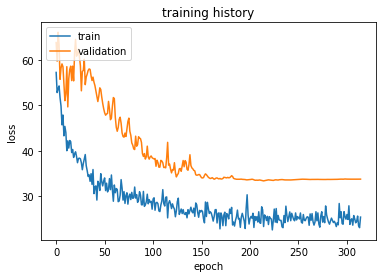

In [59]:
# train
history = model.fit(
    batch_size=4,             # adjust as training set expands
    validation_batch_size=2,  # adjust as training set expands
    callbacks=callbacks,
    epochs=800,
    n_workers=8,
    steps_per_epoch=None,     # set to None for automatic determination
)

# plot training
ax = plt.axes(title='training history', xlabel='epoch', ylabel='loss')
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper left');